In [1]:
from pyspark.sql import SparkSession
from delta.pip_utils import configure_spark_with_delta_pip 
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col,when

In [2]:
builder = SparkSession.builder \
    .appName("EntrenarModeloFraude") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

spark = configure_spark_with_delta_pip(builder).getOrCreate()

your 131072x1 screen size is bogus. expect trouble
25/11/30 23:50:29 WARN Utils: Your hostname, Danae resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/11/30 23:50:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/madri/.ivy2/cache
The jars for the packages stored in: /home/madri/.ivy2/jars
io.delta#delta-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-a597f2f6-5aea-4705-aac0-dbb33fa99e96;1.0
	confs: [default]
	found io.delta#delta-spark_2.12;3.0.0 in central
	found io.delta#delta-storage;3.0.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
:: resolution report :: resolve 830ms :: artifacts dl 24ms
	:: modules in use:
	io.delta#delta-spark_2.12;3.0.0 from central in [default]
	io.delta#delta-storage;3.0.0 from central in [default]
	org.antlr#antlr4-runtime;4.9.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   3   |   0  

In [4]:

DELTA_PATH = "/home/madri/scripts_PP-main/delta_lake_features"
print(f"Leyendo Delta Lake (con features) desde: {DELTA_PATH}")

df_modelo_input = spark.read.format("delta").load(DELTA_PATH)

print("¡Tabla de features lista para el modelo!")
df_modelo_input.printSchema()


Leyendo Delta Lake (con features) desde: /home/madri/scripts_PP-main/delta_lake_features


¡Tabla de features lista para el modelo!
root
 |-- tipo_transaccion: string (nullable = true)
 |-- id_transaccion: integer (nullable = true)
 |-- id_cliente: integer (nullable = true)
 |-- nombre_cliente: string (nullable = true)
 |-- cuenta_origen: double (nullable = true)
 |-- fecha: string (nullable = true)
 |-- monto: double (nullable = true)
 |-- divisa: string (nullable = true)
 |-- ciudad: string (nullable = true)
 |-- cuenta_destino: double (nullable = true)
 |-- categoria: string (nullable = true)
 |-- hora_movimiento: timestamp (nullable = true)
 |-- concepto_movimiento: string (nullable = true)
 |-- saldo_previo: double (nullable = true)
 |-- saldo_posterior: double (nullable = true)
 |-- canal_transaccion: string (nullable = true)
 |-- medio_pago: string (nullable = true)
 |-- estatus: string (nullable = true)
 |-- fraude_probable: string (nullable = true)
 |-- es_fraude: integer (nullable = true)
 |-- fecha_dt: date (nullable = true)
 |-- hora_del_dia: integer (nullable = 

In [5]:
# === PASO 1: Preparar el DataFrame para el Pipeline ===
from pyspark.sql.functions import col

# El pipeline de ML de Spark necesita que la columna objetivo se llame "label"
df_modelo_input = df_modelo_input.withColumnRenamed("es_fraude", "label")

In [7]:
# === PASO 2: Definir las Columnas ===

# Tus features numéricas (las que ya creaste)
columnas_numericas = [
    "feat_horario_riesgo",
    "feat_tipo_riesgo",
    "feat_canal_riesgo",
    "feat_log_monto",
    "feat_ratio_monto_vs_tipo",
    "monto" # Incluir el monto original también es útil
]

# Tus features categóricas (las originales que el modelo también usará)
columnas_categoricas = [
    "tipo_transaccion", 
    "canal_transaccion", 
    "categoria", 
    "divisa", 
    "estatus", 
    "medio_pago", 
    "ciudad"
]

In [8]:
# === PASO 3: Crear los "Stages" del Pipeline ===

# Stage 1: Convertir strings categóricos a índices numéricos
# (Ej: "App movil" -> 0.0, "Web" -> 1.0)
indexer = StringIndexer(
    inputCols=columnas_categoricas, 
    outputCols=[c + "_idx" for c in columnas_categoricas],
    handleInvalid="keep" # Si aparece una categoría nueva, la agrupa
)

# Stage 2: Aplicar One-Hot Encoding a esos índices
# (Convierte "0.0" en un vector [1, 0, 0])
encoder = OneHotEncoder(
    inputCols=indexer.getOutputCols(),
    outputCols=[c + "_ohe" for c in columnas_categoricas]
)

# Stage 3: Ensamblar TODO en un solo vector de features
# (Junta tus features numéricas + las nuevas categóricas codificadas)
features_list = columnas_numericas + encoder.getOutputCols()
assembler = VectorAssembler(
    inputCols=features_list,
    outputCol="features",
    handleInvalid="keep"
)

# Stage 4: El Modelo (Usaremos un Random Forest)
# Es robusto, bueno para empezar y maneja bien el desbalance.
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    seed=42
)

# 97.46% (194921) No-Fraude vs 2.54% (5079) Fraude
# Peso = Total No-Fraude / Total Fraude = 194921 / 5079 = 38.38
ratio_peso = 194921 / 5079

df_modelo_ponderado = df_modelo_input.withColumn("classWeight",
    when(col("label") == 1, ratio_peso).otherwise(1.0)
)

In [9]:
# === PASO 4: Crear el Pipeline ===
# (Definir indexer, encoder, assembler... igual que antes)
# ...

# MEJORA: Decirle al modelo que use la columna de peso
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    weightCol="classWeight",  # Usamos la ponderación
    numTrees=100,
    maxDepth=10,
    seed=42
)

pipeline = Pipeline(stages=[indexer, encoder, assembler, rf])


In [10]:
# === PASO 5: Dividir Datos ===
# Usamos el DataFrame ponderado
(train_data, test_data) = df_modelo_ponderado.randomSplit([0.8, 0.2], seed=42)

print(f"Datos de entrenamiento (para CV): {train_data.count()}")
print(f"Datos de prueba (finales): {test_data.count()}")

25/11/30 23:51:38 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Datos de entrenamiento (para CV): 160255


Datos de prueba (finales): 39745


In [12]:
# === PASO 6: Definir el Evaluador y el CrossValidator ===
evaluator = BinaryClassificationEvaluator(
    rawPredictionCol="rawPrediction",
    labelCol="label",
    metricName="areaUnderPR"
)

# --- ESTA ES LA CORRECCIÓN ---
# 1. Crear una parrilla de parámetros (aunque esté vacía)
paramGrid = ParamGridBuilder().build() 

# 2. Definir el CrossValidator CON la parrilla
cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,  # <-- ESTA LÍNEA ES LA QUE FALTA Y ARREGLA EL ERROR
    evaluator=evaluator,
    numFolds=5,
    seed=42
)
# --- FIN DE LA CORRECCIÓN ---

In [13]:

# === PASO 7: Entrenar el Modelo (AHORA SÍ FUNCIONARÁ) ===
print("\nEntrenando con Cross-Validation (esto tardará más)...")
cv_model = cv.fit(train_data)

print("¡Modelo entrenado y validado!")


Entrenando con Cross-Validation (esto tardará más)...


25/11/30 23:52:47 WARN DAGScheduler: Broadcasting large task binary with size 1147.5 KiB
25/11/30 23:52:49 WARN DAGScheduler: Broadcasting large task binary with size 1420.6 KiB
25/11/30 23:52:52 WARN DAGScheduler: Broadcasting large task binary with size 1720.7 KiB
25/11/30 23:53:00 WARN DAGScheduler: Broadcasting large task binary with size 1321.9 KiB
25/11/30 23:53:25 WARN DAGScheduler: Broadcasting large task binary with size 1169.6 KiB
25/11/30 23:53:27 WARN DAGScheduler: Broadcasting large task binary with size 1455.3 KiB
25/11/30 23:53:29 WARN DAGScheduler: Broadcasting large task binary with size 1760.0 KiB
25/11/30 23:53:34 WARN DAGScheduler: Broadcasting large task binary with size 1279.8 KiB
25/11/30 23:54:11 WARN DAGScheduler: Broadcasting large task binary with size 1275.2 KiB
25/11/30 23:54:15 WARN DAGScheduler: Broadcasting large task binary with size 1623.1 KiB
25/11/30 23:54:18 WARN DAGScheduler: Broadcasting large task binary with size 2004.7 KiB
25/11/30 23:54:28 WAR

¡Modelo entrenado y validado!


In [14]:
# === PASO 8: Hacer Predicciones en Datos de PRUEBA ===
# Usamos 'cv_model' (que contiene el mejor modelo de los 5)
# para predecir en los datos de 'test_data' que NUNCA VIO.
print("Realizando predicciones en el conjunto de prueba...")
predictions = cv_model.transform(test_data)

Realizando predicciones en el conjunto de prueba...


In [15]:
# === PASO 9: Evaluar el Modelo (Resultados Finales) ===
# Calculamos la métrica en el conjunto de prueba
area_under_pr_final = evaluator.evaluate(predictions)

# Calcular la Matriz de Confusión
print("Calculando Matriz de Confusión Final...")
tp = predictions.filter("label == 1 AND prediction == 1").count()
tn = predictions.filter("label == 0 AND prediction == 0").count()
fp = predictions.filter("label == 0 AND prediction == 1").count()
fn = predictions.filter("label == 1 AND prediction == 0").count()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\n--- Resultados de Evaluación Finales (Post-CV) ---")
print(f"Área bajo la curva PR (en test_data): {area_under_pr_final:.4f}")
print("---")
print(f"Verdaderos Positivos (Fraudes Atrapados): {tp}")
print(f"Verdaderos Negativos (Inocentes Ignorados): {tn}")
print("---")
print(f"Falsos Positivos (Inocentes Molestados): {fp}")
print(f"Falsos Negativos (Fraudes Perdidos): {fn}")
print("---")
print(f"Precisión Final: {precision:.2%}")
print(f"Recall Final: {recall:.2%}")

25/11/30 23:56:55 WARN DAGScheduler: Broadcasting large task binary with size 1510.9 KiB


Calculando Matriz de Confusión Final...


25/11/30 23:56:58 WARN DAGScheduler: Broadcasting large task binary with size 1513.4 KiB
25/11/30 23:57:00 WARN DAGScheduler: Broadcasting large task binary with size 1513.4 KiB
25/11/30 23:57:03 WARN DAGScheduler: Broadcasting large task binary with size 1513.4 KiB
25/11/30 23:57:05 WARN DAGScheduler: Broadcasting large task binary with size 1513.4 KiB



--- Resultados de Evaluación Finales (Post-CV) ---
Área bajo la curva PR (en test_data): 0.9951
---
Verdaderos Positivos (Fraudes Atrapados): 976
Verdaderos Negativos (Inocentes Ignorados): 38412
---
Falsos Positivos (Inocentes Molestados): 357
Falsos Negativos (Fraudes Perdidos): 0
---
Precisión Final: 73.22%
Recall Final: 100.00%


--- Importancia de las Variables (Feature Importance) ---
Top 10 Variables más influyentes en el modelo:
    Feature_Index  Importancia
5               5     0.328871
3               3     0.296623
4               4     0.201778
11             11     0.041515
0               0     0.026347
25             25     0.024320
6               6     0.016513
12             12     0.010368
26             26     0.008540
23             23     0.008432


/tmp/ipykernel_26010/4216959653.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importance, x="Importancia", y="Feature_Index", orient="h", palette="viridis")


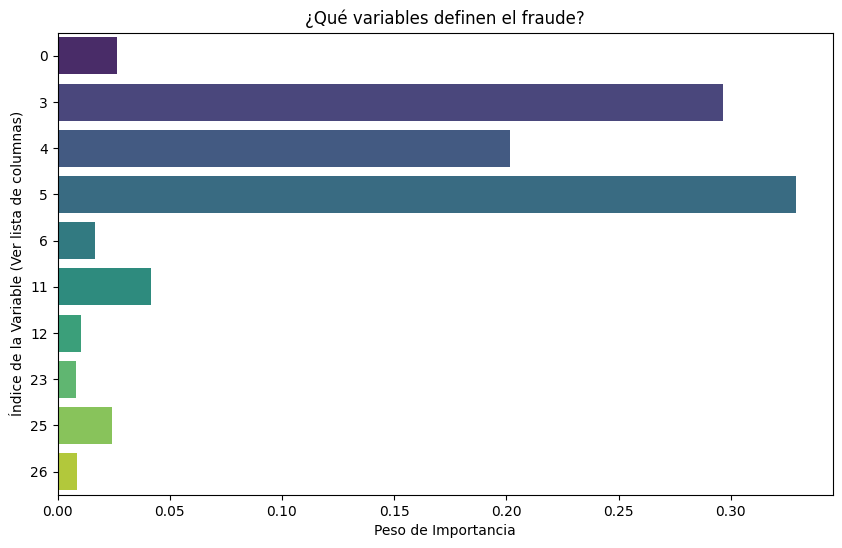


Referencia de Índices (Primeras variables):
Índice 0: feat_horario_riesgo
Índice 1: feat_tipo_riesgo
Índice 2: feat_canal_riesgo
Índice 3: feat_log_monto
Índice 4: feat_ratio_monto_vs_tipo
Índice 5: monto


In [16]:
import pandas as pd

print("--- Importancia de las Variables (Feature Importance) ---")

# 1. Extraer el mejor modelo del CrossValidator
best_pipeline_model = cv_model.bestModel

# 2. Extraer el Random Forest del Pipeline (es la última etapa, stage[-1])
rf_model = best_pipeline_model.stages[-1]

# 3. Obtener las importancias
importancias = rf_model.featureImportances

# 4. Mapear nombres (Esto es un aproximado porque OHE cambia los nombres, pero sirve)
# Combinamos numéricas + categóricas para tener una referencia
nombres_features = columnas_numericas + [c + "_encoded" for c in columnas_categoricas]

# Crear un DataFrame de Pandas para verlo bonito
df_importance = pd.DataFrame({
    "Feature_Index": range(len(importancias)),
    "Importancia": importancias.toArray()
})

# Ordenar por importancia
df_importance = df_importance.sort_values(by="Importancia", ascending=False).head(10)

print("Top 10 Variables más influyentes en el modelo:")
print(df_importance)

# 5. Graficar
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=df_importance, x="Importancia", y="Feature_Index", orient="h", palette="viridis")
plt.title("¿Qué variables definen el fraude?")
plt.xlabel("Peso de Importancia")
plt.ylabel("Índice de la Variable (Ver lista de columnas)")
plt.show()

# Imprimimos la lista de tus columnas numéricas para que compares con el índice 0, 1, 2...
print("\nReferencia de Índices (Primeras variables):")
for i, col_name in enumerate(columnas_numericas):
    print(f"Índice {i}: {col_name}")

In [19]:
import os

# 1. Extraer el mejor modelo (el ganador) del CrossValidator
best_model = cv_model.bestModel

# 2. Definir la ruta
# Nota: Usamos una ruta absoluta y nos aseguramos que la carpeta exista
BASE_PATH = "/home/madri/scripts_PP-main/modelos/machine_learning"
MODEL_NAME = "random_forest_fraude_final"
FULL_PATH = os.path.join(BASE_PATH, MODEL_NAME)

# 3. Asegurar que el directorio padre exista (Evita error de 'path not found')
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
    print(f"Directorio creado: {BASE_PATH}")

print(f"Guardando el MEJOR modelo entrenado en: {FULL_PATH}")

# 4. Guardar SOLO el mejor modelo
# Usamos .write().overwrite().save() sobre 'best_model', no sobre 'cv_model'
best_model.write().overwrite().save(FULL_PATH)

print(f"¡Modelo guardado con éxito!")

Directorio creado: /home/madri/scripts_PP-main/modelos/machine_learning
Guardando el MEJOR modelo entrenado en: /home/madri/scripts_PP-main/modelos/machine_learning/random_forest_fraude_final


¡Modelo guardado con éxito!


In [26]:
%pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 14.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 9.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


--- Generando Gráficas de Evaluación Avanzadas ---
Procesando datos para graficar... (esto puede tardar unos segundos)


25/12/01 00:11:38 WARN DAGScheduler: Broadcasting large task binary with size 1534.1 KiB


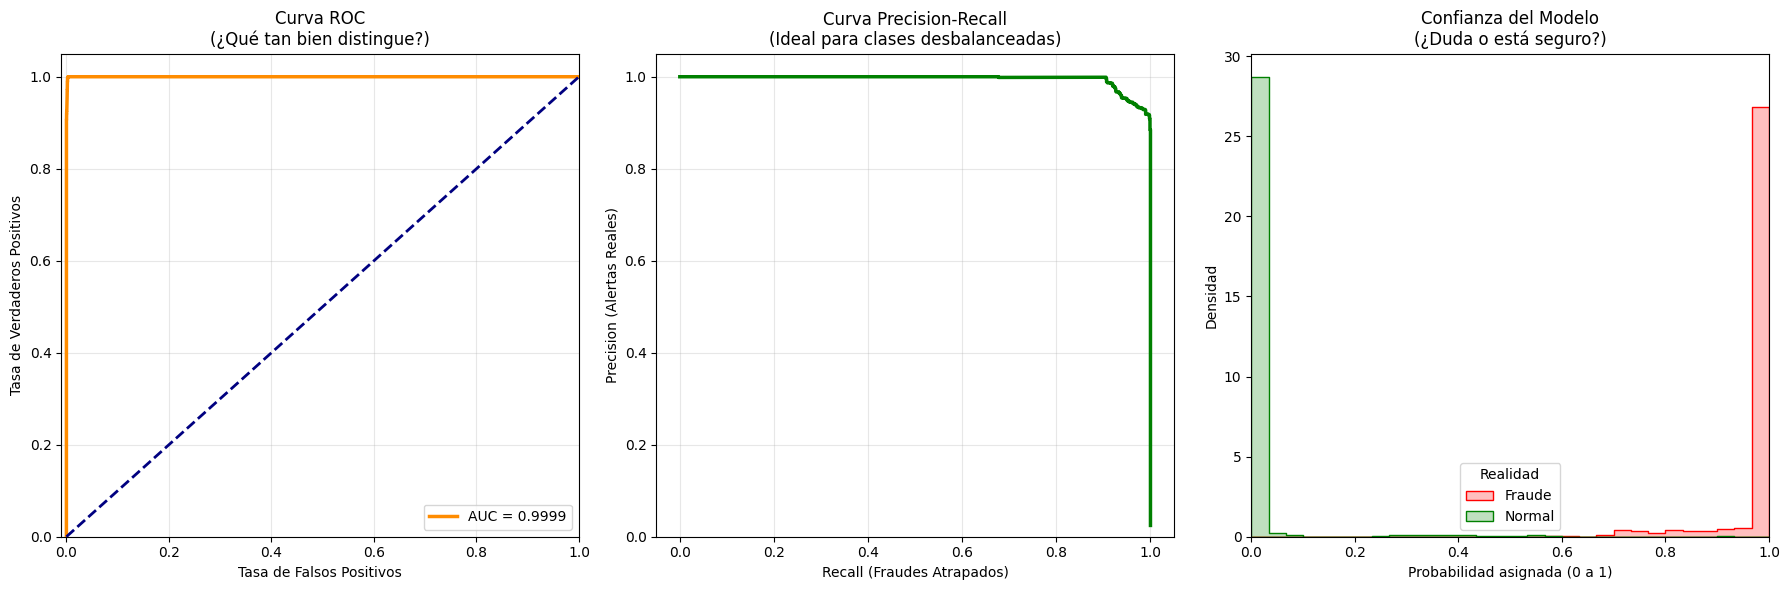

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve

print("--- Generando Gráficas de Evaluación Avanzadas ---")

# 1. CONVERTIR SPARK A PANDAS
# Necesitamos pasar los datos a la memoria local para usar Matplotlib
# Seleccionamos solo las columnas necesarias para no saturar la RAM
print("Procesando datos para graficar... (esto puede tardar unos segundos)")
preds_df = predicciones_prueba.select("label", "probability").toPandas()

# 2. EXTRAER LA PROBABILIDAD DE FRAUDE
# En Spark, 'probability' es un vector [prob_no_fraude, prob_fraude].
# Queremos solo la segunda parte (índice 1).
preds_df['prob_fraude'] = preds_df['probability'].apply(lambda x: x[1])

# 3. CONFIGURAR EL LIENZO (3 Gráficas en 1)
plt.figure(figsize=(18, 6))

# --- GRÁFICA A: Curva ROC (Capacidad de Separación) ---
fpr, tpr, _ = roc_curve(preds_df['label'], preds_df['prob_fraude'])
roc_auc = auc(fpr, tpr)

plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2.5, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC\n(¿Qué tan bien distingue?)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# --- GRÁFICA B: Curva Precision-Recall (Calidad) ---
precision, recall, _ = precision_recall_curve(preds_df['label'], preds_df['prob_fraude'])

plt.subplot(1, 3, 2)
plt.plot(recall, precision, color='green', lw=2.5)
plt.xlabel('Recall (Fraudes Atrapados)')
plt.ylabel('Precision (Alertas Reales)')
plt.title('Curva Precision-Recall\n(Ideal para clases desbalanceadas)')
plt.grid(alpha=0.3)
plt.ylim([0.0, 1.05])

# --- GRÁFICA C: Distribución de Confianza (Seguridad) ---
plt.subplot(1, 3, 3)
sns.histplot(
    data=preds_df, 
    x='prob_fraude', 
    hue='label', 
    bins=30, 
    palette={0: "green", 1: "red"}, 
    element="step", 
    stat="density", 
    common_norm=False
)
plt.title('Confianza del Modelo\n(¿Duda o está seguro?)')
plt.xlabel('Probabilidad asignada (0 a 1)')
plt.ylabel('Densidad')
plt.legend(title='Realidad', labels=['Fraude', 'Normal'])
plt.xlim(0, 1)

plt.tight_layout()
plt.show()

/tmp/ipykernel_3553/1402009588.py:51: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3553/1402009588.py:51: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


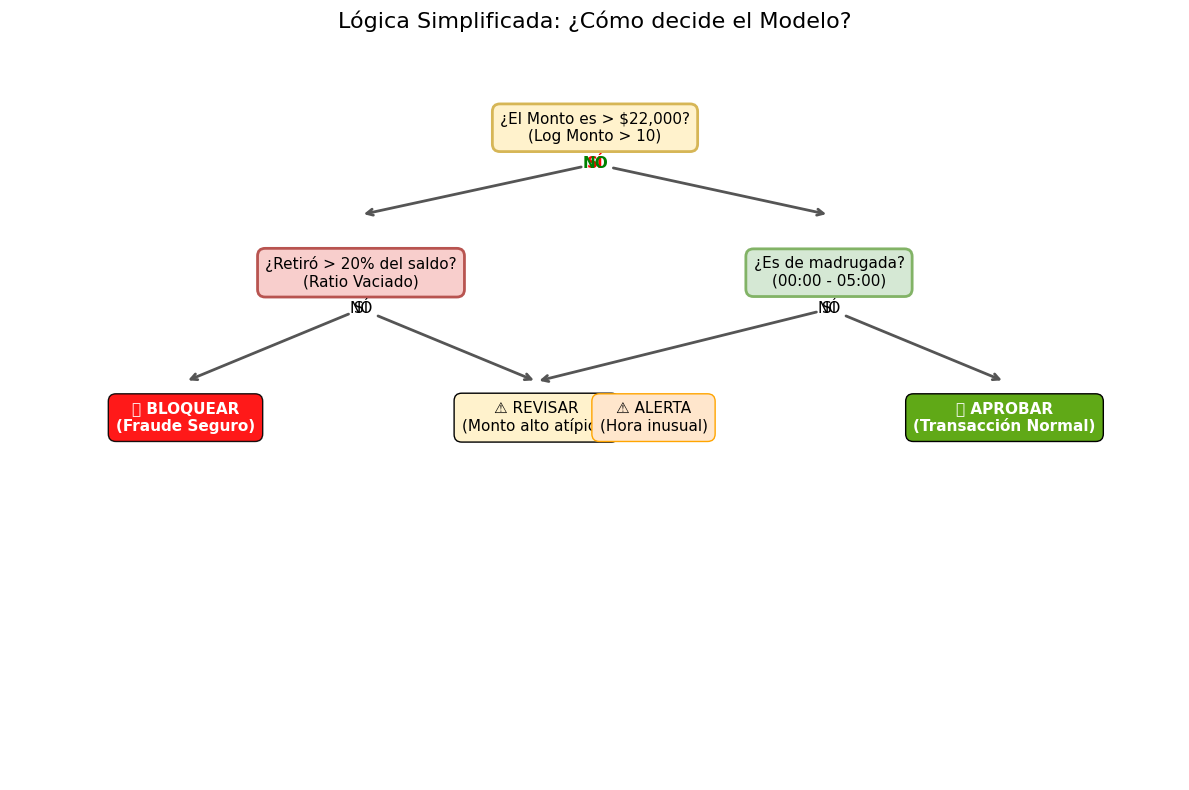

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.axis('off')

# Configuración de estilo
caja_estilo = dict(boxstyle="round,pad=0.5", fc="white", ec="#333", lw=2)
flecha_estilo = dict(arrowstyle="->", lw=2, color="#555")
texto_estilo = dict(ha="center", va="center", fontsize=11, fontfamily='sans-serif')

# --- NODO 1: EL FILTRO PRINCIPAL ---
plt.text(0.5, 0.9, "¿El Monto es > $22,000?\n(Log Monto > 10)", 
         bbox=dict(boxstyle="round,pad=0.5", fc="#FFF2CC", ec="#D6B656", lw=2), **texto_estilo)

# Flechas
plt.annotate("SÍ", xy=(0.3, 0.78), xytext=(0.5, 0.85), arrowprops=flecha_estilo, **texto_estilo, color="red", fontweight="bold")
plt.annotate("NO", xy=(0.7, 0.78), xytext=(0.5, 0.85), arrowprops=flecha_estilo, **texto_estilo, color="green", fontweight="bold")

# --- NODO 2: LOS CHEQUEOS SECUNDARIOS ---
# Izquierda (Monto Alto) -> Checar Vaciado
plt.text(0.3, 0.7, "¿Retiró > 20% del saldo?\n(Ratio Vaciado)", 
         bbox=dict(boxstyle="round,pad=0.5", fc="#F8CECC", ec="#B85450", lw=2), **texto_estilo)

# Derecha (Monto Bajo) -> Checar Hora
plt.text(0.7, 0.7, "¿Es de madrugada?\n(00:00 - 05:00)", 
         bbox=dict(boxstyle="round,pad=0.5", fc="#D5E8D4", ec="#82B366", lw=2), **texto_estilo)

# --- NODO 3: LAS DECISIONES FINALES ---
# 1. Fraude Obvio
plt.annotate("SÍ", xy=(0.15, 0.55), xytext=(0.3, 0.65), arrowprops=flecha_estilo, **texto_estilo)
plt.text(0.15, 0.5, "🚨 BLOQUEAR\n(Fraude Seguro)", 
         bbox=dict(boxstyle="round,pad=0.5", fc="#FF0000", ec="black", alpha=0.9), color="white", **texto_estilo, fontweight="bold")

# 2. Revisión Manual
plt.annotate("NO", xy=(0.45, 0.55), xytext=(0.3, 0.65), arrowprops=flecha_estilo, **texto_estilo)
plt.text(0.45, 0.5, "⚠️ REVISAR\n(Monto alto atípico)", 
         bbox=dict(boxstyle="round,pad=0.5", fc="#FFF2CC", ec="black"), **texto_estilo)

# 3. Alerta Menor
plt.annotate("SÍ", xy=(0.45, 0.55), xytext=(0.7, 0.65), arrowprops=flecha_estilo, **texto_estilo)
plt.text(0.55, 0.5, "⚠️ ALERTA\n(Hora inusual)", 
         bbox=dict(boxstyle="round,pad=0.5", fc="#FFE6CC", ec="orange"), **texto_estilo)

# 4. Aprobado
plt.annotate("NO", xy=(0.85, 0.55), xytext=(0.7, 0.65), arrowprops=flecha_estilo, **texto_estilo)
plt.text(0.85, 0.5, "✅ APROBAR\n(Transacción Normal)", 
         bbox=dict(boxstyle="round,pad=0.5", fc="#60A917", ec="black"), color="white", **texto_estilo, fontweight="bold")

plt.title("Lógica Simplificada: ¿Cómo decide el Modelo?", fontsize=16, pad=20)
plt.tight_layout()
plt.show()